In [1]:
import random
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

from trajdata import AgentBatch, AgentType, UnifiedDataset
from trajdata.data_structures.batch_element import AgentBatchElement
from trajdata.maps import VectorMap
from trajdata.utils.arr_utils import transform_angles_np, transform_coords_np
from trajdata.utils.state_utils import transform_state_np_2d
from trajdata.visualization.vis import plot_agent_batch

In [2]:
def get_closest_lane_point(element: AgentBatchElement) -> np.ndarray:
    """Closest lane for predicted agent."""

    # Transform from agent coordinate frame to world coordinate frame.
    vector_map: VectorMap = element.vec_map
    world_from_agent_tf = np.linalg.inv(element.agent_from_world_tf)
    agent_future_xyzh_world = transform_state_np_2d(
        element.agent_future_np, world_from_agent_tf
    ).as_format("x,y,z,h")

    # Use cached kdtree to find closest lane point
    lane_points = []
    for point_xyzh in agent_future_xyzh_world:
        possible_lanes = vector_map.get_current_lane(point_xyzh)
        xyzh_on_lane = np.full((1, 4), np.nan)
        if len(possible_lanes) > 0:
            xyzh_on_lane = possible_lanes[0].center.project_onto(point_xyzh[None, :3])
            xyzh_on_lane[:, :2] = transform_coords_np(
                xyzh_on_lane[:, :2], element.agent_from_world_tf
            )
            xyzh_on_lane[:, -1] = transform_angles_np(
                xyzh_on_lane[:, -1], element.agent_from_world_tf
            )

        lane_points.append(xyzh_on_lane)

    lane_points = np.concatenate(lane_points, axis=0)
    return lane_points


Loading data for matched scene tags: ['boston-nusc_mini-mini_train', 'nusc_mini-mini_train-singapore']


Calculating Agent Data (Serially): 100%|██████████| 8/8 [00:00<00:00, 16139.70it/s]


8 scenes in the scene index.


Structuring Agent Data Index: 100%|██████████| 8/8 [00:00<00:00, 10926.22it/s]


# Data Samples: 11,046
(48, 4)
(48, 4)
(48, 4)


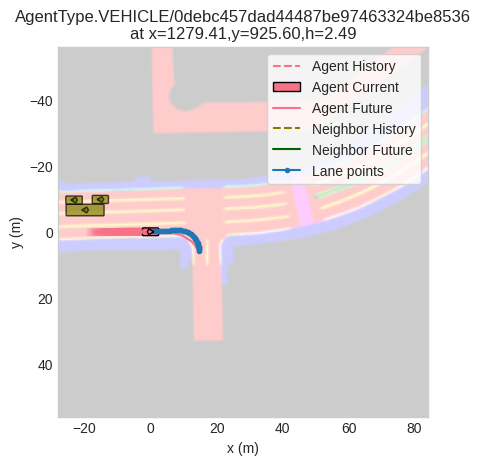

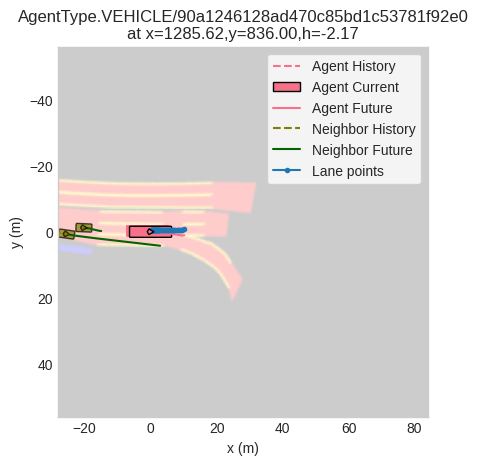

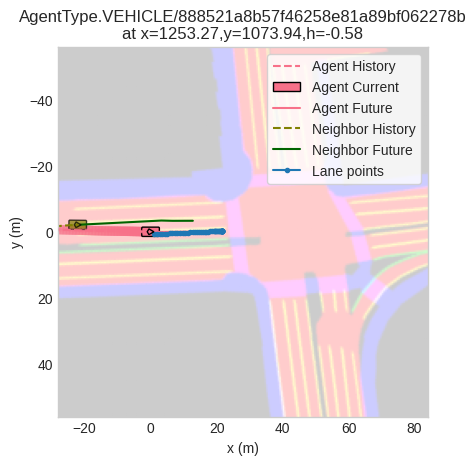

In [6]:
dataset = UnifiedDataset(
    desired_data=[
        "nusc_mini-mini_train",
        # "lyft_sample-mini_val",
    ],
    centric="agent",
    desired_dt=0.1,
    history_sec=(3.2, 3.2),
    future_sec=(4.8, 4.8),
    only_types=[AgentType.VEHICLE],
    state_format="x,y,z,xd,yd,xdd,ydd,h",
    obs_format="x,y,z,xd,yd,xdd,ydd,s,c",
    agent_interaction_distances=defaultdict(lambda: 30.0),
    incl_robot_future=False,
    incl_raster_map=True,
    raster_map_params={
        "px_per_m": 2,
        "map_size_px": 224,
        "offset_frac_xy": (-0.5, 0.0),
    },
    incl_vector_map=True,
    num_workers=0,
    verbose=True,
    data_dirs={  # Remember to change this to match your filesystem!
        "nusc_mini": "data/nuScenes/v1.0-mini_root",
        # "lyft_sample": "~/datasets/lyft/scenes/sample.zarr",
    },
    # A dictionary that contains functions that generate our custom data.
    # Can be any function and has access to the batch element.
    extras={
        "closest_lane_point": get_closest_lane_point,
    },
)

print(f"# Data Samples: {len(dataset):,}")

dataloader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=dataset.get_collate_fn(),
    num_workers=0,
)

# Visualize selected examples
num_plots = 3
batch_idxs = [10876, 10227, 1284]
# batch_idxs = random.sample(range(len(dataset)), num_plots)
batch: AgentBatch = dataset.get_collate_fn(pad_format="right")(
    [dataset[i] for i in batch_idxs]
)
assert "closest_lane_point" in batch.extras

for batch_i in range(num_plots):
    ax = plot_agent_batch(
        batch, batch_idx=batch_i, legend=False, show=False, close=False
    )
    lane_points = batch.extras["closest_lane_point"][batch_i]
    lane_points = lane_points[
        torch.logical_not(torch.any(torch.isnan(lane_points), dim=1)), :
    ].numpy()
    print(lane_points.shape)

    ax.plot(
        lane_points[:, 0],
        lane_points[:, 1],
        "o-",
        markersize=3,
        label="Lane points",
    )

    ax.legend(loc="best", frameon=True)

plt.show()
plt.close("all")